In [881]:
import tensorflow.keras as keras
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
from tqdm import tqdm
from scipy.stats import multivariate_normal

(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()
y_train, y_test = y_train[:, 0], y_test[:, 0]

In [882]:

from skimage.transform import resize
(X_ood, _), _ = keras.datasets.mnist.load_data()

X_ood = X_ood[np.random.choice(range(len(X_ood)), int(len(X_ood) / 20))]

_X_ood = np.zeros((len(X_ood), 28, 28, 3))

for k in range(3):
    _X_ood[:, :, :, k] = X_ood

X_ood = np.array([resize(_X_ood[i], (32, 32)) for i in tqdm(range(len(X_ood)))])
'''
indices_of_ood_subclasses = np.where(y_train >= 2)[0]
indices_of_ood_subclasses = np.random.choice(indices_of_ood_subclasses, int(len(X_train) / 20))
X_ood = X_train[indices_of_ood_subclasses]
'''

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:02<00:00, 1017.37it/s]


'\nindices_of_ood_subclasses = np.where(y_train >= 2)[0]\nindices_of_ood_subclasses = np.random.choice(indices_of_ood_subclasses, int(len(X_train) / 20))\nX_ood = X_train[indices_of_ood_subclasses]\n'

In [883]:

indices_of_subclasses = np.where(y_train < 2)[0]
X_train, y_train = X_train[indices_of_subclasses], y_train[indices_of_subclasses]

#random_indices = np.random.choice(range(len(y_test)), 1000, replace = False)
#X_train, y_train = X_train[random_indices], y_train[random_indices]
#random_indices = np.random.choice(range(len(y_test)), 500, replace = False)
#X_test, y_test = X_test[random_indices], y_test[random_indices]
indices_of_subclasses = np.where(y_test < 2)[0]
X_test, y_test = X_test[indices_of_subclasses], y_test[indices_of_subclasses]

In [853]:
#load and train model 
inp = keras.layers.Input(np.shape(X_train)[1:])

x = keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(inp)
x = keras.layers.MaxPooling2D()(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(x)
x = keras.layers.MaxPooling2D()(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Flatten()(x)


x = keras.layers.Dense(units=1024, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(units=512, activation='relu')(x)
enc = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.2)(x)
cls_logits = keras.layers.Dense(units=len(np.unique(y_train)), activation = 'linear')(enc)
cls_out = keras.layers.Activation('softmax', name = 'cls_out')(cls_logits)

network = keras.models.Model(inputs = inp, outputs = cls_out)
encoder = keras.models.Model(inputs = inp, outputs = enc)
network.compile(loss='categorical_crossentropy',
          optimizer=keras.optimizers.Adam(learning_rate=3e-4),
          metrics = ['acc'])
network.fit(X_train, keras.utils.to_categorical(y_train), 
    epochs = 15,
    verbose = 1,
    validation_split = .1)

Epoch 1/15
282/282 [==============================] - 3s 7ms/step - loss: 0.4220 - acc: 0.8390 - val_loss: 0.2752 - val_acc: 0.8940
Epoch 2/15
282/282 [==============================] - 2s 6ms/step - loss: 0.2629 - acc: 0.8941 - val_loss: 0.2585 - val_acc: 0.9110
Epoch 3/15
282/282 [==============================] - 2s 6ms/step - loss: 0.2033 - acc: 0.9196 - val_loss: 0.1916 - val_acc: 0.9280
Epoch 4/15
282/282 [==============================] - 2s 6ms/step - loss: 0.1647 - acc: 0.9394 - val_loss: 0.2218 - val_acc: 0.9110
Epoch 5/15
282/282 [==============================] - 2s 6ms/step - loss: 0.1304 - acc: 0.9491 - val_loss: 0.1646 - val_acc: 0.9370
Epoch 6/15
282/282 [==============================] - 2s 6ms/step - loss: 0.1195 - acc: 0.9529 - val_loss: 0.1653 - val_acc: 0.9380
Epoch 7/15
282/282 [==============================] - 2s 6ms/step - loss: 0.0988 - acc: 0.9616 - val_loss: 0.1659 - val_acc: 0.9400
Epoch 8/15
282/282 [==============================] - 2s 6ms/step - loss: 0.

In [854]:
encoding_X_train = encoder.predict(X_train).reshape(X_train.shape[0], -1)
encoding_X_test = encoder.predict(X_test).reshape(X_test.shape[0], -1)

In [884]:
encoding_X_ood = encoder.predict(X_ood).reshape(X_ood.shape[0], -1)

In [1073]:
class_means, class_lower_percentile, class_upper_percentile = [], [], []
for c in range(len(np.unique(y_train))):
    examples_of_class = np.where(y_train == c)[0]
    class_means.append(np.mean(encoding_X_train[examples_of_class], axis = 0))
    class_lower_percentile.append(np.percentile(np.sqrt(np.sum((encoding_X_train[examples_of_class] - class_means[c]) ** 2, axis = 1)), 55))
    class_upper_percentile.append(np.percentile(np.sqrt(np.sum((encoding_X_train[examples_of_class] - class_means[c]) ** 2, axis = 1)), 100))

  0%|                                                                                                                                                                                                                                                     | 0/2 [00:00<?, ?it/s]

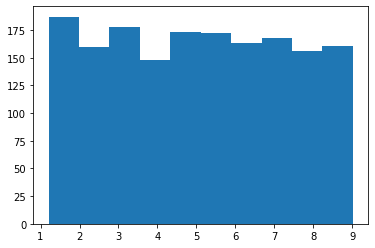

 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                      | 1/2 [00:00<00:00,  1.94it/s]

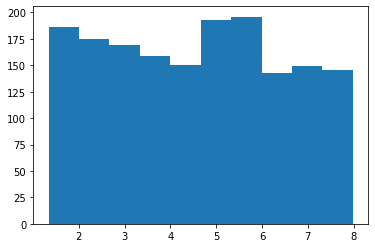

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.95it/s]


In [1076]:
from scipy.stats import multivariate_normal as mv
vos_samples = []
for c in tqdm(range(len(np.unique(y_train)))):
    examples_of_class = np.where(y_train == c)[0]
    vos_samples_of_class = mv.rvs(mean = 0, cov = 1, size = (int(len(examples_of_class) / 3), np.shape(encoding_X_train)[1]))
    vos_samples_of_class = vos_samples_of_class / np.linalg.norm(vos_samples_of_class, axis =1)[:, np.newaxis]
    magnitudes = np.random.uniform(class_lower_percentile[c], class_upper_percentile[c], size = len(vos_samples_of_class))
    vos_samples_of_class = class_means[c] + vos_samples_of_class * magnitudes[:, np.newaxis]
    non_data_uncertainty_vos_samples_of_class = []
    distances = []
    for sample in vos_samples_of_class:
        is_distant = True
        distance = np.inf
        for j in range(len(np.unique(y_train))):
            if j != c:
                distance_from_other_class_center = np.sqrt(np.sum((sample - class_means[j]) ** 2)) / class_lower_percentile[j]
                if distance_from_other_class_center < distance:
                    distance = distance_from_other_class_center
        distances.append(distance)
        if distance > 6:
            non_data_uncertainty_vos_samples_of_class.append(sample)
    plt.hist(distances)
    plt.show()
    vos_samples.extend(non_data_uncertainty_vos_samples_of_class)

In [1077]:
ood_X_train = np.concatenate([encoding_X_train, vos_samples], axis = 0)
ood_y_train = np.concatenate([keras.utils.to_categorical(y_train), np.ones((len(vos_samples), len(np.unique(y_train)))) / len(np.unique(y_train))])

In [1078]:
import tensorflow as tf
x = keras.layers.Dense(100, activation = 'relu')(enc)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(100, activation = 'relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(100, activation = 'relu')(x)
x = keras.layers.BatchNormalization()(x)
pre_temperature = keras.layers.Dense(units = 1, activation = 'linear')(x)
#temperature = keras.layers.Lambda(lambda v : keras.activations.sigmoid(v) * 10)(pre_temperature)
#custom loss. We want the temperature to be unbounded on the positive side (and therefore when the pretemperature is greater than 0, it's unbounded; 
#but we also need to make sure the temperature is never negative - so we don't get infinite logits. So we do an exponentially decaying activation on the negative side)
temperature = keras.layers.Activation(lambda v : tf.where(v < 0, keras.activations.exponential(v), 1 + keras.activations.linear(v)))(pre_temperature)
ood_cls_logits = keras.layers.Lambda(lambda inputs: inputs[0] / inputs[1])([cls_logits, temperature])
ood_cls_out = keras.layers.Activation('softmax')(ood_cls_logits)

temperature_model = keras.models.Model(inputs = enc, outputs = temperature)
ood_network = keras.models.Model(inputs = enc, outputs = ood_cls_out)
for layer in network.layers:
    layer.trainable = False
ood_network.compile(loss='categorical_crossentropy',
          optimizer=keras.optimizers.Adam(learning_rate=3e-3))
ood_network.fit(ood_X_train, ood_y_train, 
    epochs = 30,
    verbose = 1,
    validation_split = .1)

Epoch 1/30
312/312 [==============================] - 3s 5ms/step - loss: 0.0813 - val_loss: 10.7390
Epoch 2/30
312/312 [==============================] - 1s 4ms/step - loss: 0.0502 - val_loss: 26.1786
Epoch 3/30
312/312 [==============================] - 1s 4ms/step - loss: 0.0407 - val_loss: 2.4253
Epoch 4/30
312/312 [==============================] - 1s 4ms/step - loss: 0.0385 - val_loss: 4.5967
Epoch 5/30
312/312 [==============================] - 1s 4ms/step - loss: 0.0393 - val_loss: 3.1920
Epoch 6/30
312/312 [==============================] - 1s 4ms/step - loss: 0.0346 - val_loss: 3.6983
Epoch 7/30
312/312 [==============================] - 1s 4ms/step - loss: 0.0354 - val_loss: 3.7510
Epoch 8/30
312/312 [==============================] - 1s 4ms/step - loss: 0.0295 - val_loss: 9.7365
Epoch 9/30
312/312 [==============================] - 1s 4ms/step - loss: 0.0307 - val_loss: 30.4442
Epoch 10/30
312/312 [==============================] - 1s 4ms/step - loss: 0.0394 - val_loss: 30.

KeyboardInterrupt: 

In [1085]:
from copy import deepcopy
import tensorflow as tf
encoding_X_ood_grad = deepcopy(encoding_X_ood)
tensor = tf.convert_to_tensor(encoding_X_ood_grad, dtype=tf.float32)
with tf.GradientTape(persistent=True) as tape:
    tape.watch(tensor)
    pred = ood_network(tensor)
    y = [pred[i, keras.backend.argmax(pred[i])] for i in range(len(pred))]
dy_dx = tape.gradient(y, tensor)
encoding_X_ood_grad -= 4e1 * dy_dx

In [1086]:
encoding_X_train_grad = deepcopy(encoding_X_train)
tensor = tf.convert_to_tensor(encoding_X_train_grad, dtype=tf.float32)
with tf.GradientTape(persistent=True) as tape:
    tape.watch(tensor)
    pred = ood_network(tensor)
    y = [pred[i, keras.backend.argmax(pred[i])] for i in range(len(pred))]
dy_dx = tape.gradient(y, tensor)
encoding_X_train_grad -= 4e1 * dy_dx

In [1087]:
t = temperature_model.predict(encoding_X_train)
print("In Distribution Temperature: ", np.mean(t))

In Distribution Temperature:  0.5172284


In [1088]:
t = temperature_model.predict(encoding_X_train_grad)
print("In Distribution Grad Temperature: ", np.mean(t))

In Distribution Grad Temperature:  0.7329862


In [1089]:
t = temperature_model.predict(np.array(vos_samples))
print("VO Temperature (we want this to be much higher than the in distribution temperature): ", np.mean(t))

VO Temperature (we want this to be much higher than the in distribution temperature):  4.3176055


In [1090]:
t = temperature_model.predict(encoding_X_ood)
print("OOD Temperature (we want this to be much higher than the in distribution temperature): ", np.mean(t))

OOD Temperature (we want this to be much higher than the in distribution temperature):  9.2319765


In [1091]:
t = temperature_model.predict(encoding_X_ood_grad)
print("OOD Grad Temperature (we want this to be much higher than the in distribution temperature): ", np.mean(t))

OOD Grad Temperature (we want this to be much higher than the in distribution temperature):  9.526242


In [1092]:
vos_pred = ood_network.predict(np.array(vos_samples))
print("Temperature Deflated VO Confidence Average (we want this to be really low): ", np.mean(np.max(vos_pred, axis = 1)))

Temperature Deflated VO Confidence Average (we want this to be really low):  0.8653182


In [1093]:
ood_pred = ood_network.predict(encoding_X_ood)
print("Temperature Deflated OOD Confidence Average (we want this to be really low): ", np.mean(np.max(ood_pred, axis = 1)))

Temperature Deflated OOD Confidence Average (we want this to be really low):  0.69136655


In [1094]:
ood_grad_pred = ood_network.predict(encoding_X_ood_grad)
print("Temperature Deflated OOD Grad Confidence Average (we want this to be really low): ", np.mean(np.max(ood_grad_pred, axis = 1)))

Temperature Deflated OOD Grad Confidence Average (we want this to be really low):  0.65577847


In [1095]:
id_pred = ood_network.predict(encoding_X_train)
print("Temperature Deflated In-Distribution Confidence Average: ", np.mean(np.max(id_pred, axis = 1)))

Temperature Deflated In-Distribution Confidence Average:  0.98821145


In [1096]:
id_grad_pred = ood_network.predict(encoding_X_train_grad)
print("Temperature Deflated In-Distribution Grad Confidence Average: ", np.mean(np.max(id_grad_pred, axis = 1)))

Temperature Deflated In-Distribution Grad Confidence Average:  0.9864173


In [1097]:
from sklearn.metrics import roc_auc_score
print("AUC: ",roc_auc_score(np.concatenate([np.ones((len(id_pred))), np.zeros((len(ood_pred)))]), np.concatenate([np.max(id_pred, axis = 1), np.max(ood_pred, axis = 1)])))
print("Grad AUC: ",roc_auc_score(np.concatenate([np.ones((len(id_grad_pred))), np.zeros((len(ood_grad_pred)))]), np.concatenate([np.max(id_grad_pred, axis = 1), np.max(ood_grad_pred, axis = 1)])))

AUC:  0.9814259000000001
Grad AUC:  0.9835589


In [1098]:
vo_pred = keras.models.Model(inputs = enc, outputs = cls_out).predict(np.array(vos_samples))
print("Unaffected Model VO Confidence Average (this being high shows networks are overconfident OOD): ", np.mean(np.max(vo_pred, axis = 1)))

Unaffected Model VO Confidence Average (this being high shows networks are overconfident OOD):  0.9610622


In [1099]:
ood_pred = keras.models.Model(inputs = enc, outputs = cls_out).predict(encoding_X_ood)
print("Unaffected Model OOD Confidence Average (this being high shows networks are overconfident OOD): ", np.mean(np.max(ood_pred, axis = 1)))

Unaffected Model OOD Confidence Average (this being high shows networks are overconfident OOD):  0.9441205


In [1100]:
ood_grad_pred = keras.models.Model(inputs = enc, outputs = cls_out).predict(encoding_X_ood_grad)
print("Unaffected Model OOD Grad Confidence Average (this being high shows networks are overconfident OOD): ", np.mean(np.max(ood_grad_pred, axis = 1)))

Unaffected Model OOD Grad Confidence Average (this being high shows networks are overconfident OOD):  0.919487


In [1101]:
id_pred = network.predict(X_train)
print("Unaffected Model In-Distribution Confidence Average: ", np.mean(np.max(id_pred, axis = 1)))

Unaffected Model In-Distribution Confidence Average:  0.9791584


In [1102]:
id_grad_pred = network.predict(X_train)
print("Unaffected Model In-Distribution Grad Confidence Average: ", np.mean(np.max(id_grad_pred, axis = 1)))

Unaffected Model In-Distribution Grad Confidence Average:  0.9791584


In [1103]:
from sklearn.metrics import roc_auc_score
print("AUC: ",roc_auc_score(np.concatenate([np.ones((len(id_pred))), np.zeros((len(ood_pred)))]), np.concatenate([np.max(id_pred, axis = 1), np.max(ood_pred, axis = 1)])))
print("Grad AUC: ",roc_auc_score(np.concatenate([np.ones((len(id_grad_pred))), np.zeros((len(ood_grad_pred)))]), np.concatenate([np.max(id_grad_pred, axis = 1), np.max(ood_grad_pred, axis = 1)])))

AUC:  0.5570987666666667
Grad AUC:  0.6500288333333333


In [1104]:
def get_ece(confidences, correctness):
    hists = []
    hists_hat = []
    amts = []
    num_bins = 100
    for i in range(num_bins):
        prop = i*1./num_bins
        inds = np.where((confidences >= prop) & (confidences <= prop+1./num_bins))[0]
        amts.append(len(inds))
        if len(inds) > 0:
            hists.append(len(np.where(correctness[inds] == 1)[0])*1./len(inds))
            hists_hat.append(np.mean(confidences[inds]))
        else:
            hists.append(prop)
            hists_hat.append(prop + 0.5/num_bins)
    return np.sum(np.abs(np.array(hists) - np.array(hists_hat)) * np.array(amts)) / np.sum(amts)

In [1105]:
from sklearn.metrics import roc_auc_score, accuracy_score
pred = network.predict(X_test)

print(roc_auc_score(np.argmax(pred, axis = 1) == y_test, np.max(pred, axis = 1)))
class_eces = []
for j in range(len(np.unique(y_train))):
    class_eces.append(get_ece(np.array(pred)[:, j], y_test == j))
np.mean(class_eces)

0.8905379496526583


0.05034628552233335

In [1106]:
pred = ood_network.predict(encoding_X_test)
print(roc_auc_score(np.argmax(pred, axis = 1) == y_test, np.max(pred, axis = 1)))
class_eces = []
for j in range(len(np.unique(y_train))):
    class_eces.append(get_ece(np.array(pred)[:, j], y_test == j))
np.mean(class_eces)

0.8458091168581059


0.05485854825760907

In [1107]:
ood_scores_test = temperature_model.predict(encoding_X_test)[:, 0]

In [1108]:
model_predictions = network.predict(X_test)
ood_model_predictions = ood_network.predict(encoding_X_test)

In [1109]:
num_intervals = 5

In [1112]:
#z_scores = p_label_error / (variance_confidences + 1e-12)
from sklearn.metrics import average_precision_score
order = np.argsort(ood_scores_test)[::-1]
ps = []
accs = []
base_eces = []
ood_model_eces = []
base_confidences = []
ood_model_confidences = []
model_acc = []
ood_model_acc = []

for i in range(0, len(y_test), int(len(y_test) / num_intervals)):
    class_eces = []
    for j in range(len(np.unique(y_train))):
        class_eces.append(get_ece(np.array(model_predictions)[order[:i + int(len(y_test) / num_intervals)], j], y_test[order[:i + int(len(y_test) / num_intervals)]] == j))
    base_eces.append(np.mean(class_eces))
    base_confidences.append(np.mean(np.max(model_predictions[order[i:i + int(len(y_test) / num_intervals)]], axis = 1)))
    model_acc.append(np.mean(np.argmax(model_predictions[order[i:i + int(len(y_test) / num_intervals)]], axis = 1) == y_test[order[i:i + int(len(y_test) / num_intervals)]]))

    class_eces = []
    for j in range(len(np.unique(y_train))):
        class_eces.append(get_ece(np.array(ood_model_predictions)[order[:i + int(len(y_test) / num_intervals)], j], y_test[order[:i + int(len(y_test) / num_intervals)]] == j))
    ood_model_eces.append(np.median(class_eces))
    ood_model_confidences.append(np.mean(np.max(ood_model_predictions[order[i:i + int(len(y_test) / num_intervals)]], axis = 1)))
    ood_model_acc.append(np.mean(np.argmax(ood_model_predictions[order[i:i + int(len(y_test) / num_intervals)]], axis = 1) == y_test[order[i:i + int(len(y_test) / num_intervals)]]))

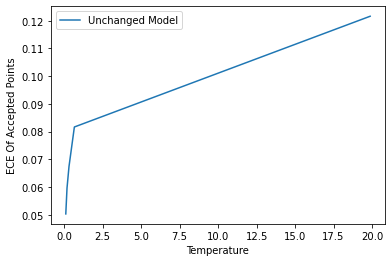

In [1113]:
import matplotlib.pyplot as plt
plt.plot(ood_scores_test[order[np.arange(0, len(y_test), int(len(y_test) / num_intervals))]], base_eces, label = "Unchanged Model")
#plt.plot(np.arange(0, len(y_test), int(len(y_test) / num_intervals)) / len(y_test), base_eces, label = "Unchanged Model")
#plt.plot(ood_scores_test[order[np.arange(0, len(y_test), int(len(y_test) / num_intervals))]], ood_model_eces, label = "Penultimate-Dependent Temperature Deflation Model")
#plt.plot(np.arange(0, len(y_test), int(len(y_test) / num_intervals)) / len(y_test), ood_model_eces, label = "Penultimate-Dependent Temperature Deflation Model")
plt.xlabel("Temperature")
plt.ylabel("ECE Of Accepted Points")
plt.legend()

The blue line increasing shows that when temperature is high, ECE is high -> we can detect when the baseline model is miscalibrated (when we're OOD) and we know it by a high temperature. On this, we deflate confidence.